# Exploratory Analysis
This notebook contains the exploratory analysis that will be developed on to produce models.

### Imports

In [1]:
import datahandler.JHU
import datahandler.WorldBank

import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb

In [2]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 300

In [3]:
# set random seeds
tf.random.set_seed(2644)
np.random.seed(2644)

In [4]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [5]:
'+'.join([pio.renderers.default, "iframe"])

'plotly_mimetype+notebook+iframe'

In [6]:
pio.renderers.default = pio.renderers.default + "+iframe"

## High-level examination

In [7]:
country_level_data = datahandler.JHU.global_case_data()

In [8]:
latest_wb_pop = datahandler.WorldBank.latest_worldbank("SP.POP.TOTL")

First we look at the current top-level global trend.

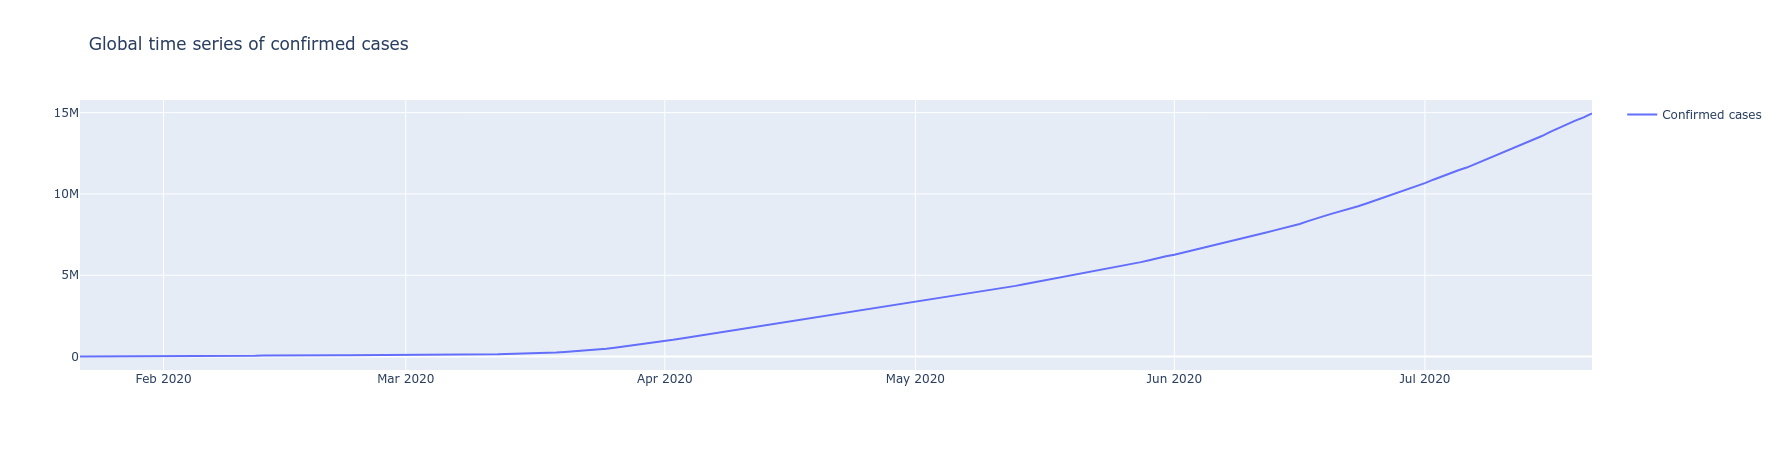

In [9]:
import plotly.graph_objects as go

fig = go.Figure(data = go.Scatter(x=country_level_data.index,
                                   y=country_level_data.sum(axis=1),
                                   name='Confirmed cases'
                                  )
               ).update_layout(title='Global time series of confirmed cases',
                               showlegend=True
                              )
fig.show()

Overall, the graph seems to be climbing steadily, possibly exponential at first, then linear? We will therefore plot a log-graph of the cases. An exponential trend should be approximately linear on a log-graph, while a linear trend would appear logarithmic (as all things should be).

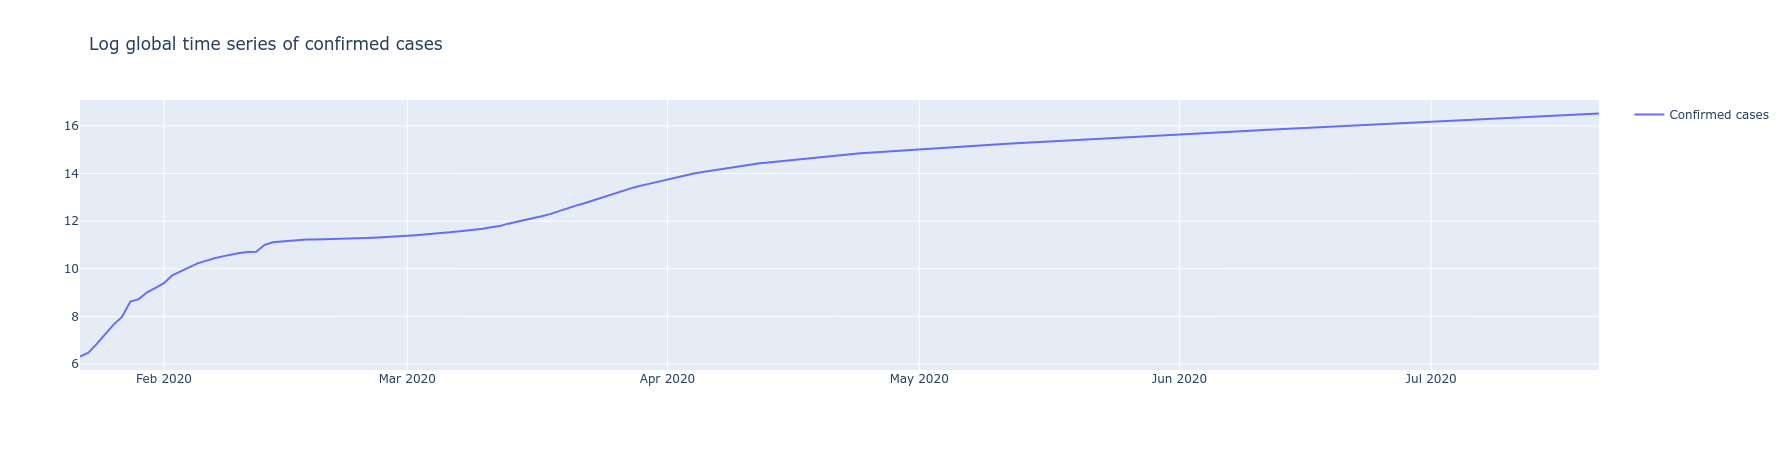

In [10]:
fig = go.Figure(data = go.Scatter(x=country_level_data.index,
                                   y=np.log(country_level_data.sum(axis=1)),
                                   name='Confirmed cases'
                                  )
               ).update_layout(title='Log global time series of confirmed cases',
                               showlegend=True
                              )
fig.show()

The logarithmic graph shows a few more interesting insights.

The initial period does appear linear, but it tails off almost linearly before experiencing a jump from 12 February to 13 February. This is of course due to the change in reporting that China adopted on that date. This gives us our first notice that we need to pay attention to such reporting discrepancies, especially since they add additional noise to the data.

The trend then starts to increase again, first linearly before a change in gradient around 12 March, when European countries started to experience their own exponential growth stage. This tails off again to a logarithmic trend after, at around the beginning of April. The trend thereafter is harder to discern visually. 

The overall trend is harder to discern, since it is comprised of different countries with their own infection patterns, with some countries/regions seeing infections rise at different times, e.g. the original spread in China vs the subsequent spread in Europe, and then in the Americas.

## Country-level breakdown
First, we try to align the case numbers meaningfully. 
### Day 0 alignment
In this case, we treat the last day on which there were no cases reported as day 0. 

In [11]:
country_level_data

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22                0        0        0        0       0   
2020-01-23                0        0        0        0       0   
2020-01-24                0        0        0        0       0   
2020-01-25                0        0        0        0       0   
2020-01-26                0        0        0        0       0   
...                     ...      ...      ...      ...     ...   
2020-07-17            35229     3906    21948      880     638   
2020-07-18            35301     4008    22549      880     687   
2020-07-19            35475     4090    23084      880     705   
2020-07-20            35526     4171    23691      884     749   
2020-07-21            35615     4290    24278      884     779   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                        0          0        0          0        0   
2020-01-23                        0          0        0          0        0   
2020-01-24                        0          0        0          0        0   
2020-01-25                        0          0        0          0        0   
2020-01-26                        0          0        0          4        0   
...                             ...        ...      ...        ...      ...   
2020-07-17                       76     119301    34001      11441    19439   
2020-07-18                       76     122524    34462      11802    19573   
2020-07-19                       76     126755    34877      12069    19655   
2020-07-20                       76     130774    34981      12428    19743   
2020-07-21                       76     136118    35254      12894    19827   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...               0        0           0          0        0   
2020-01-23      ...               0        0           0          0        2   
2020-01-24      ...               0        0           0          0        2   
2020-01-25      ...               0        0           0          0        2   
2020-01-26      ...               0        0           0          0        2   
...             ...             ...      ...         ...        ...      ...   
2020-07-17      ...          294803     1037       15607      11191      382   
2020-07-18      ...          295632     1044       16186      11483      382   
2020-07-19      ...          296358     1054       16752      11891      383   
2020-07-20      ...          296944     1064       17149      12334      384   
2020-07-21      ...          297389     1096       17881      12774      401   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                       0               0      0       0         0  
2020-01-23                       0               0      0       0         0  
2020-01-24                       0               0      0       0         0  
2020-01-25                       0               0      0       0         0  
2020-01-26                       0               0      0       0         0  
...                            ...             ...    ...     ...       ...  
2020-07-17                    7764              10   1576    2810      1420  
2020-07-18                    8204              10   1581    2980      1478  
2020-07-19                    8549              10   1606    2980      1611  
2020-07-20                    8916              10   1619    3326      1713  
2020-07-21                    9228              10   1629    3386      1820  

[182 rows x 188 columns]

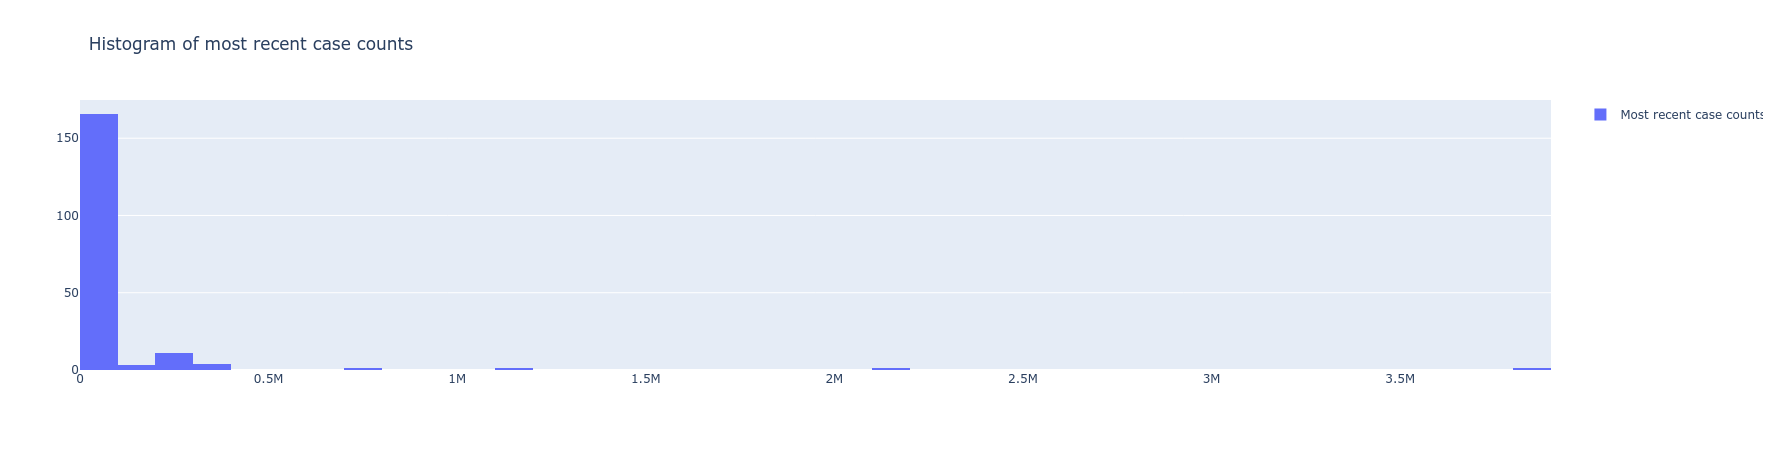

In [12]:
fig = go.Figure(data=[go.Histogram(x=country_level_data.iloc[-1, :],
                                   name='Most recent case counts'
                                  ),
                     ]).update_layout(title='Histogram of most recent case counts',
                                      showlegend=True
                                     )
fig.show()

In [13]:
datahandler.JHU.first_crossed(country_level_data, 1)

Country/Region
Afghanistan           2020-03-08
Albania               2020-03-09
Algeria               2020-03-02
Andorra               2020-03-16
Angola                2020-03-21
                         ...    
West Bank and Gaza    2020-03-05
Western Sahara        2020-04-05
Yemen                 2020-04-29
Zambia                2020-03-18
Zimbabwe              2020-03-21
Length: 188, dtype: object

In [14]:
datahandler.JHU.align_cases(country_level_data, 1)

Afghanistan  Albania  Algeria  Andorra  Angola  Antigua and Barbuda  \
0            1.0      0.0      1.0      1.0     1.0                  1.0   
1            4.0      2.0      3.0      2.0     2.0                  3.0   
2            4.0     10.0      5.0     39.0     2.0                  3.0   
3            5.0     12.0     12.0     39.0     3.0                  3.0   
4            7.0     23.0     12.0     53.0     3.0                  7.0   
..           ...      ...      ...      ...     ...                  ...   
177          NaN      NaN      NaN      NaN     NaN                  NaN   
178          NaN      NaN      NaN      NaN     NaN                  NaN   
179          NaN      NaN      NaN      NaN     NaN                  NaN   
180          NaN      NaN      NaN      NaN     NaN                  NaN   
181          NaN      NaN      NaN      NaN     NaN                  NaN   

     Argentina  Armenia  Australia  Austria  ...  United Kingdom  Uruguay  \
0          1.0      1.0        0.0      0.0  ...             0.0      0.0   
1          2.0      4.0        4.0      2.0  ...             2.0      4.0   
2          8.0      8.0        5.0      2.0  ...             2.0      6.0   
3         12.0     18.0        5.0      3.0  ...             2.0      8.0   
4         12.0     26.0        6.0      3.0  ...             8.0     29.0   
..         ...      ...        ...      ...  ...             ...      ...   
177        NaN      NaN    12428.0      NaN  ...             NaN      NaN   
178        NaN      NaN    12894.0      NaN  ...             NaN      NaN   
179        NaN      NaN        NaN      NaN  ...             NaN      NaN   
180        NaN      NaN        NaN      NaN  ...             NaN      NaN   
181        NaN      NaN        NaN      NaN  ...             NaN      NaN   

     Uzbekistan  Venezuela  Vietnam  West Bank and Gaza  Western Sahara  \
0           1.0        0.0      0.0                 0.0             0.0   
1           6.0        2.0      2.0                 4.0             4.0   
2          10.0       10.0      2.0                 7.0             4.0   
3          15.0       17.0      2.0                16.0             4.0   
4          23.0       33.0      2.0                16.0             4.0   
..          ...        ...      ...                 ...             ...   
177         NaN        NaN    382.0                 NaN             NaN   
178         NaN        NaN    382.0                 NaN             NaN   
179         NaN        NaN    383.0                 NaN             NaN   
180         NaN        NaN    384.0                 NaN             NaN   
181         NaN        NaN    401.0                 NaN             NaN   

     Yemen  Zambia  Zimbabwe  
0      1.0     0.0       1.0  
1      6.0     2.0       3.0  
2      6.0     2.0       3.0  
3      7.0     2.0       3.0  
4     10.0     2.0       3.0  
..     ...     ...       ...  
177    NaN     NaN       NaN  
178    NaN     NaN       NaN  
179    NaN     NaN       NaN  
180    NaN     NaN       NaN  
181    NaN     NaN       NaN  

[182 rows x 188 columns]

As we can observe, the data collection started after some countries had already recorded cases, while other countries did not record any cases for a while into the collection of the dataset. In order to produce a meaningful split, we therefore need to identify the shortest time since the first case was recorded for any country in our dataset.

In [15]:
dates_of_first_cases = datahandler.JHU.first_crossed(country_level_data, 1)
days_with_cases = {x: len(country_level_data[x][dates_of_first_cases[x]-dt.timedelta(1):]) for x in dates_of_first_cases.index}
print(f"Shortest time since first case recorded: {min(days_with_cases, key=days_with_cases.get)} ({days_with_cases[min(days_with_cases, key=days_with_cases.get)]} days)")

Shortest time since first case recorded: Lesotho (62 days)


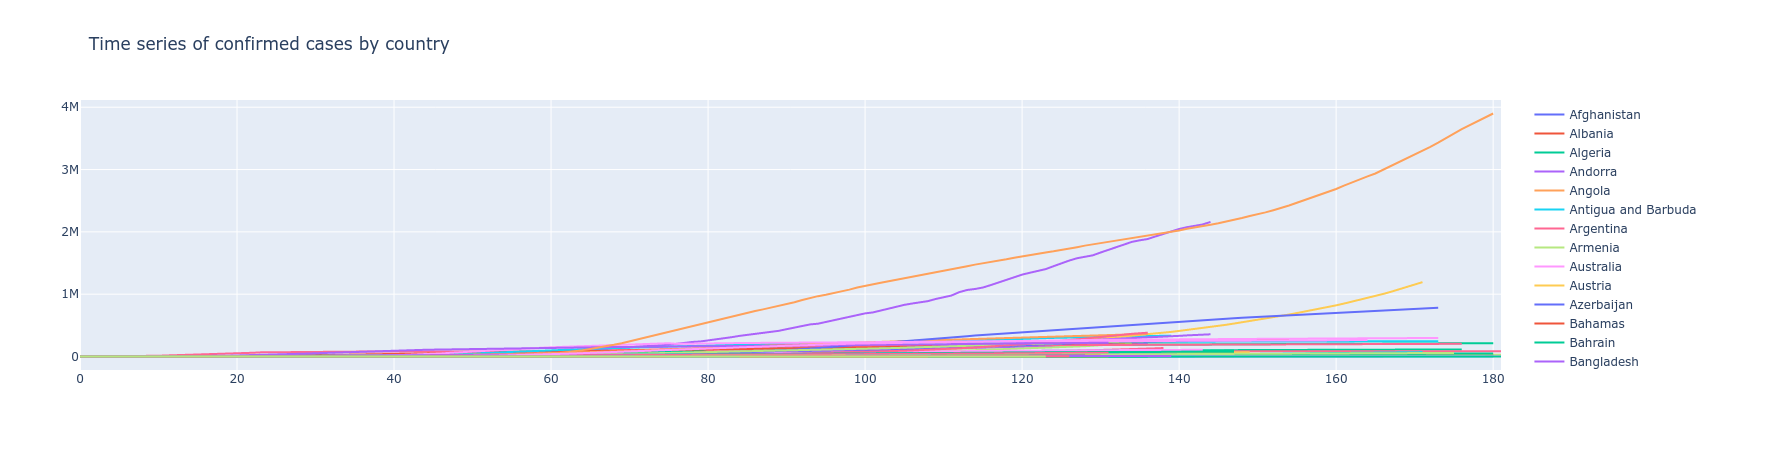

In [16]:
#def generate_scatter_from_column

aligned_1 = datahandler.JHU.align_cases(country_level_data, 1)

fig = go.Figure(data = [go.Scatter(x=aligned_1.index,
                                   y=aligned_1[country].values,
                                   name=country
                                  ) for country in aligned_1.columns]
               ).update_layout(title='Time series of confirmed cases by country',
                               showlegend=True
                              )
fig.show()

The graph appears to show 2 outlier paths, as is rather well known, in the form of the US and Brazil. Apart from that however, most paths are fairly shallow. At this point, fitting a simple linear model regressing on past values would be of interest, as a baseline. While we would expect it to be far out, it can serve as the basis for more sophisticated models.

#### Linear model
This section makes the following assumptions:
* There are no population differences between countries.
    * While this is demonstrably false, a correction requires at the minimum a regression for each country, or additional population information (which will be introduced in later models).
* 2 weeks is sufficient data (the incubation period tends to be around 2 weeks or less). 
* That the dataset starts after some countries have already had cases recorded doesn't matter, since it's mostly the sequences that matter.

This section therefore aims to take the following steps:
1. Create the dataset for the regression.
    * While this is a straightforward model and may not require a validation set, one will be set up anyway so that other models (e.g. cross-validation) can be trained, and used for evaluation on the test set.
    * An arbitrary 60-20-20 split will be used for the train-validation-test split.
        * Because the split involves a time series, the split will have to take place in sequential order (train set before validation, validation set before test), so that the model can retain its usefulness for prediction of future values.
            * The data will be split for each country first, before being added together, to preserve the balance of classes (again, for potential future use).
2. Fit the model on the training set.
3. Test the model on the test set, collecting the MSE.

In [17]:
def train_val_test_split_old(df, seq_length: int):
    '''Splits the input dataframe into train, validation, and test. This function first defines an inner function that operates on a column, returning three dataframes containing the respective sets.
    '''
    def _process_column(df, seq_length: int, col: str):
        print(f"Processing: {col}")
        temp = df[col].dropna()
        n = len(temp) - seq_length + 1
        result = [temp[x:x+seq_length] for x in range(n)]
        test_len = int(n/5)
        train_len = n - (2 * test_len)
        return (result[:train_len], result[train_len:train_len+test_len], result[train_len+test_len:])
    
    train_set = []
    val_set = []
    test_set = []
    
    for col in df.columns:
        train_temp, val_temp, test_temp = _process_column(df, seq_length, col)
        train_set += train_temp
        val_set += val_temp
        test_set += test_temp
        
    train_set = pd.DataFrame([x.reset_index(drop=True) for x in train_set])
    val_set = pd.DataFrame([x.reset_index(drop=True) for x in val_set])
    test_set = pd.DataFrame([x.reset_index(drop=True) for x in test_set])
    return train_set, val_set, test_set

In [18]:
train_df, val_df, test_df = train_val_test_split_old(aligned_1, 15)
train_val_df = train_df.append(val_df)

Processing: Afghanistan
Processing: Albania
Processing: Algeria
Processing: Andorra
Processing: Angola
Processing: Antigua and Barbuda
Processing: Argentina
Processing: Armenia
Processing: Australia
Processing: Austria
Processing: Azerbaijan
Processing: Bahamas
Processing: Bahrain
Processing: Bangladesh
Processing: Barbados
Processing: Belarus
Processing: Belgium
Processing: Belize
Processing: Benin
Processing: Bhutan
Processing: Bolivia
Processing: Bosnia and Herzegovina
Processing: Botswana
Processing: Brazil
Processing: Brunei
Processing: Bulgaria
Processing: Burkina Faso
Processing: Burma
Processing: Burundi
Processing: Cabo Verde
Processing: Cambodia
Processing: Cameroon
Processing: Canada
Processing: Central African Republic
Processing: Chad
Processing: Chile
Processing: China
Processing: Colombia
Processing: Comoros
Processing: Congo (Brazzaville)
Processing: Congo (Kinshasa)
Processing: Costa Rica
Processing: Cote d'Ivoire
Processing: Croatia
Processing: Cuba
Processing: Cyprus

In [19]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

LinearRegression()

In [20]:
train_y_pred = regr.predict(train_df.iloc[:, :-1])
print(f"Training set MSE: {mean_squared_error(train_df.iloc[:, -1], train_y_pred)}")
print(f"Training set R^2: {r2_score(train_df.iloc[:, -1], train_y_pred)}")

Training set MSE: 208048.65891055882
Training set R^2: 0.9999464463836938


In [21]:
test_y_pred = regr.predict(test_df.iloc[:, :-1])
print(f"Test set MSE: {mean_squared_error(test_df.iloc[:, -1], test_y_pred)}")
print(f"Test set R^2: {r2_score(test_df.iloc[:, -1], test_y_pred)}")

Test set MSE: 689562.7280302397
Test set R^2: 0.9999924353181985


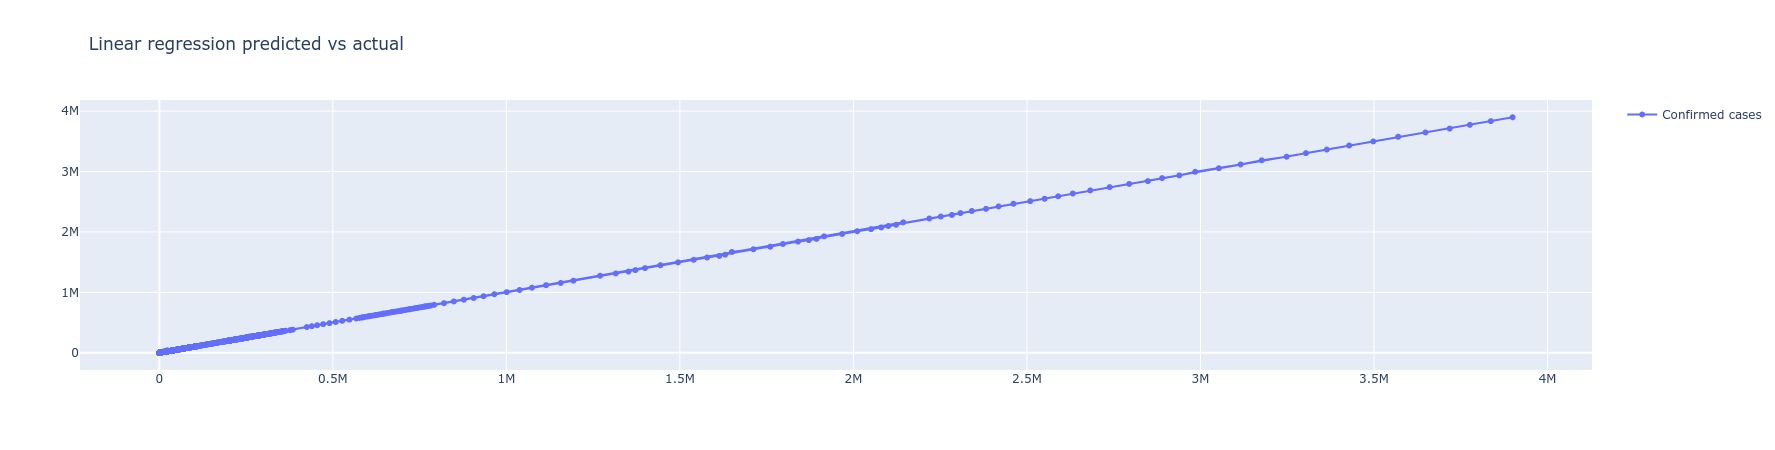

In [22]:
fig = go.Figure(data = go.Scatter(x=test_y_pred,
                                  y=test_df.iloc[:, -1],
                                  mode='lines+markers',
                                  name='Confirmed cases'
                                 )
               ).update_layout(title='Linear regression predicted vs actual',
                               showlegend=True
                              )
fig.show()

Immediately, a problem can be noticed. $R^2$ and MSE do not seem to be very good metrics to use to evaluate the suitability of this regression model. The MSE would be heavily biased by the larger values, as a missed prediction of 1% would be vastly different for predicted values of 1,000 (10), vs 1,000,000 (10,000). In this case, given that the case count is expected to keep increasing, with a range of case counts from the low hundreds to the millions, the MSE could mask the problems with predictions of lower values. If this is the case, we need to find a metric which will measure the value of the error relative to the value of the actual/predicted counts.

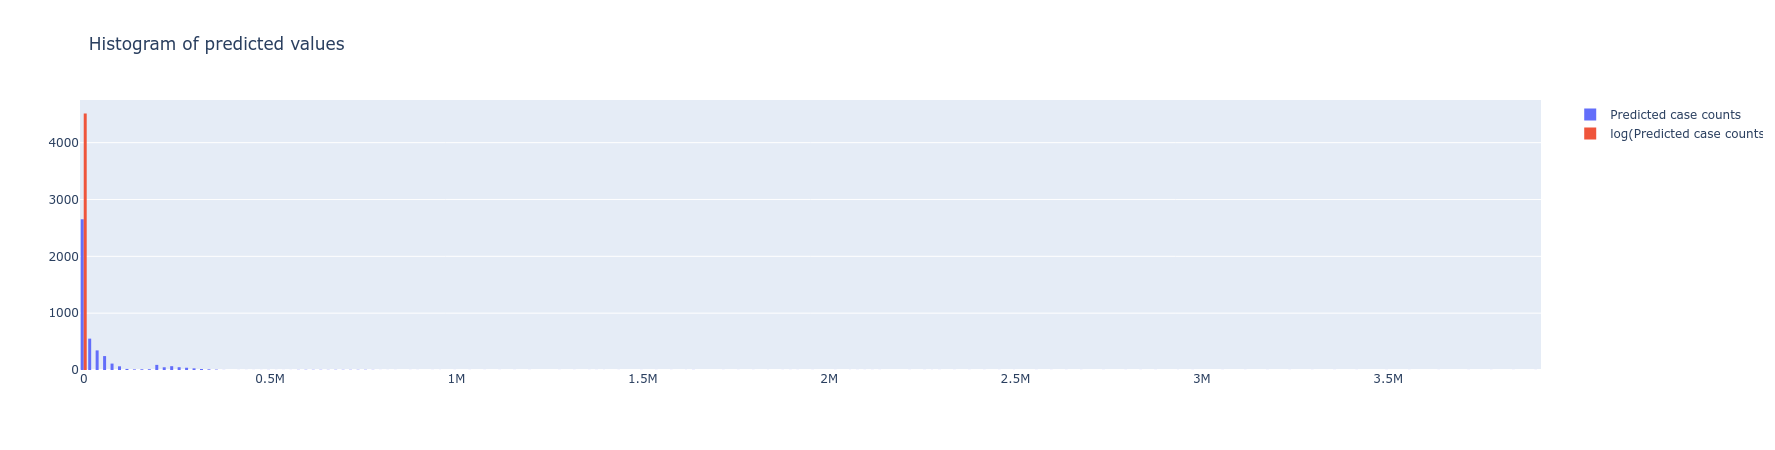

In [23]:
fig = go.Figure(data=[go.Histogram(x=test_y_pred,
                                   name='Predicted case counts'
                                  ),
                      go.Histogram(x=np.log(test_y_pred),
                                  name='log(Predicted case counts)'
                                  )
                     ]).update_layout(title='Histogram of predicted values',
                                      showlegend=True
                                     )
fig.show()

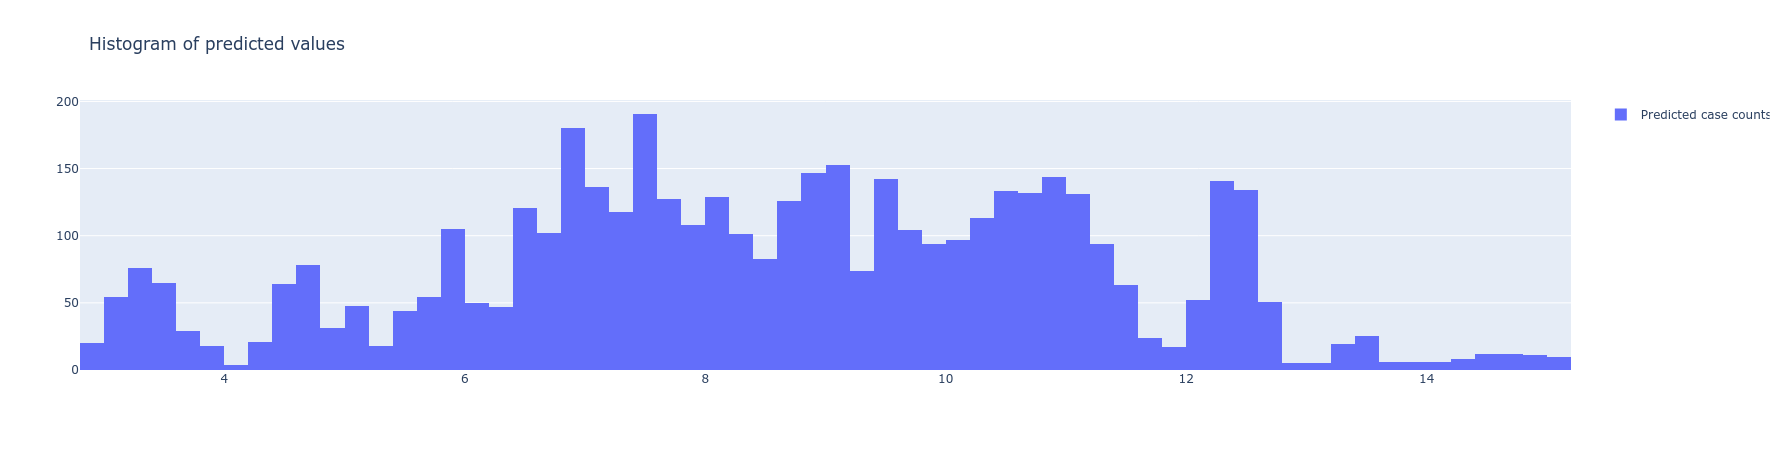

In [24]:
fig = go.Figure(data=[go.Histogram(x=np.log(test_y_pred),
                                   name='Predicted case counts'
                                  )]).update_layout(title='Histogram of predicted values',
                                                    showlegend=True
                                                   )
fig.show()

The histogram suggests that the predicted values are approximately exponentially distributed. This suggests the use of the mean squared log error (MSLE):

$$ \text{MSLE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2. $$

According to the [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), the mean squared log error _"is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc."_ This is indeed the current use-case, where the dependent variable is a population count, and is monitored over time, with exponential growth as seen above.

The use of the MSLE also brings other advantages, such as a higher penalisation of under-prediction as opposed to over-prediction, due to the nature of the logarithmic function. It is also more robust to outliers, since once again, the logarithmic function reduces the effect of an outlier value.

In [25]:
print(f"Training set MSLE: {mean_squared_log_error(train_df.iloc[:, -1], train_y_pred)}")
print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], test_y_pred)}")

Training set MSLE: 0.06715061091963487
Test set MSLE: 0.01474679516122529


Curiously, the error in the training set seems to be higher than the error in the test set.

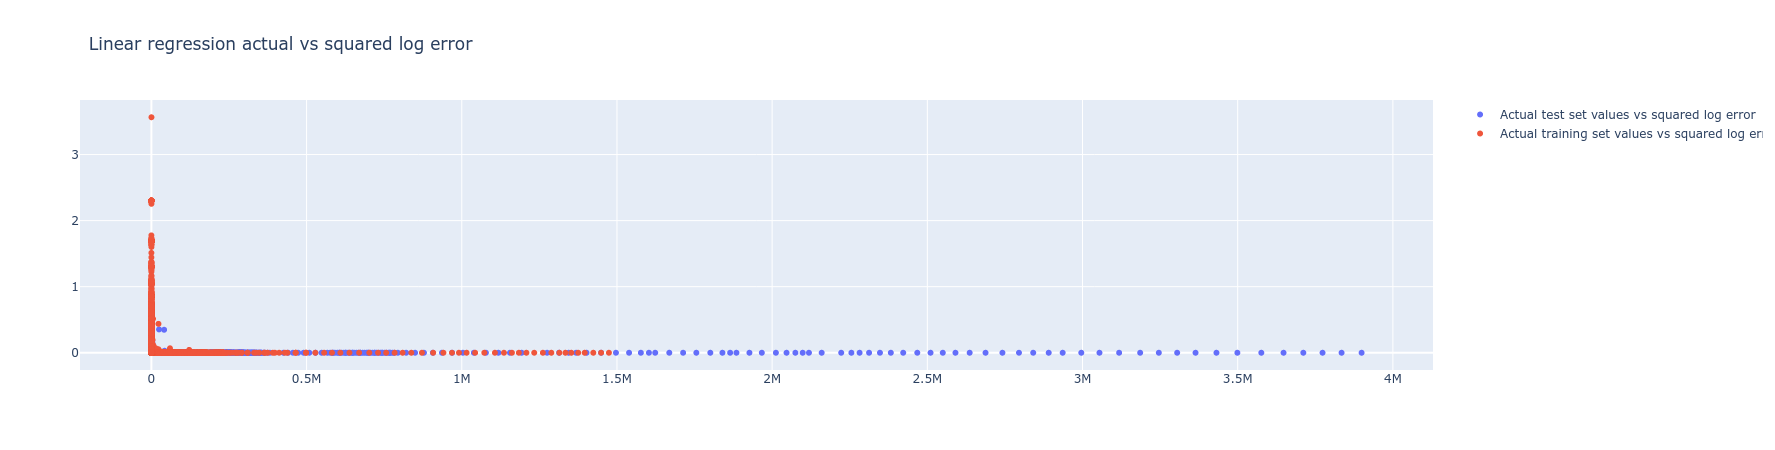

In [26]:
fig = go.Figure(data = [go.Scatter(x=test_df.iloc[:, -1],
                                   y=(np.log(1+test_df.iloc[:, -1]) - np.log(1+test_y_pred))**2,
                                   mode='markers',
                                   name='Actual test set values vs squared log error'
                                  ),
                        go.Scatter(x=train_df.iloc[:, -1],
                                   y=(np.log(1+train_df.iloc[:, -1]) - np.log(1+train_y_pred))**2,
                                   mode='markers',
                                   name='Actual training set values vs squared log error'
                                  )]
               ).update_layout(title='Linear regression actual vs squared log error',
                               showlegend=True
                              )
fig.show()

Plotting the values of the linear regression against the squared log error for both training set and test set (the plot can be manipulated above), it can be observed that the squared log error is highest for lower values. This suggests that the model is not doing well where case counts are much lower values, which would explain the lower test set error, since the training set contains values which are lower, since the training set consists of values preceding the test set values temporally.

This suggests that MSLE cannot be ruled out for comparison between models, which would be training and running on the same data. It also suggests that the simple linear regression model is not a very good model for smaller case counts. This model may however be used as a baseline, which will be doing going forward. As for its relevance with regards to prediction, by now, most countries have seen infections, and few are at levels low enough where the predictions may be a problem. Given the observations above, as time passes, we should in fact expect to see the error levels decrease. For a more directly comparable result however, we will have to train the model on both the training set and the validation set, then predict on the test set in order to obtain its results for a better basis of comparison, as we will be training all models on a concatenation of the training set to the validation set once selected.

A major theoretical issue with using this model however, is that the observations are required to be independent and identically distributed (i.i.d.). However, this is not the case here, as the dataset is cobbled together from past observations of case counts from all countries. This violates the assumption doubly:
* Observations from different countries may not (and are probably not) i.i.d.
    * This point is in fact utilised later by introducing country-specific data, such as population count, urbanisation measures, and lockdown control measures.
* By the nature of the chosen features, we are explicitly searching for a correlation between past values and future values.
    * The next model we explore in fact, will explore this relationship further.

In [27]:
regr_test = linear_model.LinearRegression()
regr_test.fit(train_val_df.iloc[:, :-1], train_val_df.iloc[:, -1])

LinearRegression()

In [28]:
regr_test_y_pred = regr_test.predict(test_df.iloc[:, :-1])
print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], regr_test_y_pred)}")

Test set MSLE: 0.016909667372277868


### Auto-correlation
Next, we examine the autocorrelation and partial autocorrelation functions of the data.

In [29]:
autocorr_df = {}
for col in aligned_1.columns:
    print(f"Processing: {col}")
    autocorr_df[col] = [aligned_1[col].diff().autocorr(lag=i) for i in range(aligned_1.dropna(axis=0).shape[0])] # truncate lags to maximum possible length
    
autocorr_df = pd.DataFrame(autocorr_df)#.dropna(axis=0)
autocorr_df

Processing: Afghanistan
Processing: Albania
Processing: Algeria
Processing: Andorra
Processing: Angola
Processing: Antigua and Barbuda
Processing: Argentina
Processing: Armenia
Processing: Australia
Processing: Austria
Processing: Azerbaijan
Processing: Bahamas
Processing: Bahrain
Processing: Bangladesh
Processing: Barbados
Processing: Belarus
Processing: Belgium
Processing: Belize
Processing: Benin
Processing: Bhutan
Processing: Bolivia
Processing: Bosnia and Herzegovina
Processing: Botswana
Processing: Brazil
Processing: Brunei
Processing: Bulgaria
Processing: Burkina Faso
Processing: Burma
Processing: Burundi
Processing: Cabo Verde
Processing: Cambodia
Processing: Cameroon
Processing: Canada
Processing: Central African Republic
Processing: Chad
Processing: Chile
Processing: China
Processing: Colombia
Processing: Comoros
Processing: Congo (Brazzaville)
Processing: Congo (Kinshasa)
Processing: Costa Rica
Processing: Cote d'Ivoire
Processing: Croatia
Processing: Cuba
Processing: Cyprus

/home/jay/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/jay/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide



Processing: Liechtenstein
Processing: Lithuania
Processing: Luxembourg
Processing: MS Zaandam
Processing: Madagascar
Processing: Malawi
Processing: Malaysia
Processing: Maldives
Processing: Mali
Processing: Malta
Processing: Mauritania
Processing: Mauritius
Processing: Mexico
Processing: Moldova
Processing: Monaco
Processing: Mongolia
Processing: Montenegro
Processing: Morocco
Processing: Mozambique
Processing: Namibia
Processing: Nepal
Processing: Netherlands
Processing: New Zealand
Processing: Nicaragua
Processing: Niger
Processing: Nigeria
Processing: North Macedonia
Processing: Norway
Processing: Oman
Processing: Pakistan
Processing: Panama
Processing: Papua New Guinea
Processing: Paraguay
Processing: Peru
Processing: Philippines
Processing: Poland
Processing: Portugal
Processing: Qatar
Processing: Romania
Processing: Russia
Processing: Rwanda
Processing: Saint Kitts and Nevis
Processing: Saint Lucia
Processing: Saint Vincent and the Grenadines
Processing: San Marino
Processing: Sa

Afghanistan   Albania   Algeria   Andorra    Angola  Antigua and Barbuda  \
0      1.000000  1.000000  1.000000  1.000000  1.000000             1.000000   
1      0.911488  0.905638  0.988642  0.459750  0.403187            -0.019196   
2      0.899960  0.900530  0.981781  0.507060  0.576953            -0.026338   
3      0.899562  0.893179  0.972877  0.517463  0.652392             0.076259   
4      0.890215  0.856055  0.962283  0.411279  0.357674            -0.006440   
..          ...       ...       ...       ...       ...                  ...   
57    -0.587562 -0.088963  0.663748  0.103974  0.341091            -0.055970   
58    -0.635923 -0.110266  0.667513  0.202474  0.122844            -0.027625   
59    -0.606140 -0.031405  0.676795  0.133188 -0.027289            -0.052043   
60    -0.632958 -0.038451  0.683441 -0.013738  0.218119            -0.058931   
61    -0.625948 -0.064003  0.684691  0.217882  0.067683            -0.059989   

    Argentina   Armenia  Australia   Austria  ...  United Kingdom   Uruguay  \
0    1.000000  1.000000   1.000000  1.000000  ...        1.000000  1.000000   
1    0.976389  0.876479   0.865542  0.818607  ...        0.973664  0.468651   
2    0.974572  0.831098   0.881199  0.818373  ...        0.942462  0.381660   
3    0.955944  0.800239   0.837072  0.799215  ...        0.917597  0.323531   
4    0.966847  0.786867   0.822275  0.814742  ...        0.908304  0.209854   
..        ...       ...        ...       ...  ...             ...       ...   
57   0.831524  0.079530  -0.325211 -0.332274  ...       -0.816541  0.201739   
58   0.814372  0.047576  -0.322053 -0.307107  ...       -0.835546 -0.005431   
59   0.815585  0.032462  -0.316693 -0.366246  ...       -0.847794  0.050014   
60   0.821915  0.036775  -0.307609 -0.336615  ...       -0.852631  0.031315   
61   0.838280  0.037142  -0.305816 -0.392471  ...       -0.852701 -0.048086   

    Uzbekistan  Venezuela   Vietnam  West Bank and Gaza  Western Sahara  \
0     1.000000   1.000000  1.000000            1.000000        1.000000   
1     0.923080   0.911387  0.389993            0.886993       -0.028138   
2     0.928581   0.892162  0.390533            0.850965       -0.028411   
3     0.932356   0.888093  0.383279            0.911818       -0.028690   
4     0.938896   0.886547  0.387836            0.868205       -0.028974   
..         ...        ...       ...                 ...             ...   
57    0.142254   0.585781 -0.056301           -0.237041       -0.034041   
58    0.136207   0.562131 -0.153623           -0.207069       -0.034749   
59    0.141419   0.501109 -0.132311           -0.208755       -0.028187   
60    0.139197   0.455908  0.010836           -0.190378       -0.028792   
61    0.110690   0.439360 -0.122273           -0.170990       -0.029423   

       Yemen    Zambia  Zimbabwe  
0   1.000000  1.000000  1.000000  
1   0.309050  0.094770  0.395148  
2   0.325856  0.030391  0.373150  
3   0.214234  0.271725  0.554944  
4   0.086529  0.012792  0.374456  
..       ...       ...       ...  
57 -0.029446  0.013102  0.155412  
58  0.344270  0.105430  0.001258  
59  0.194486  0.087775  0.158045  
60 -0.239323 -0.025067  0.127276  
61 -0.040732  0.211898  0.017283  

[62 rows x 188 columns]

In [30]:
autocorr_df.dropna()

Afghanistan   Albania   Algeria   Andorra    Angola  Antigua and Barbuda  \
0     1.000000  1.000000  1.000000  1.000000  1.000000             1.000000   
1     0.911488  0.905638  0.988642  0.459750  0.403187            -0.019196   
2     0.899960  0.900530  0.981781  0.507060  0.576953            -0.026338   
3     0.899562  0.893179  0.972877  0.517463  0.652392             0.076259   
4     0.890215  0.856055  0.962283  0.411279  0.357674            -0.006440   

   Argentina   Armenia  Australia   Austria  ...  United Kingdom   Uruguay  \
0   1.000000  1.000000   1.000000  1.000000  ...        1.000000  1.000000   
1   0.976389  0.876479   0.865542  0.818607  ...        0.973664  0.468651   
2   0.974572  0.831098   0.881199  0.818373  ...        0.942462  0.381660   
3   0.955944  0.800239   0.837072  0.799215  ...        0.917597  0.323531   
4   0.966847  0.786867   0.822275  0.814742  ...        0.908304  0.209854   

   Uzbekistan  Venezuela   Vietnam  West Bank and Gaza  Western Sahara  \
0    1.000000   1.000000  1.000000            1.000000        1.000000   
1    0.923080   0.911387  0.389993            0.886993       -0.028138   
2    0.928581   0.892162  0.390533            0.850965       -0.028411   
3    0.932356   0.888093  0.383279            0.911818       -0.028690   
4    0.938896   0.886547  0.387836            0.868205       -0.028974   

      Yemen    Zambia  Zimbabwe  
0  1.000000  1.000000  1.000000  
1  0.309050  0.094770  0.395148  
2  0.325856  0.030391  0.373150  
3  0.214234  0.271725  0.554944  
4  0.086529  0.012792  0.374456  

[5 rows x 188 columns]

One issue that we faced when first exploring this data, is that after dropping the autocorrelation function values which were NaN, we had 5 values left. We also had errors occurring randomly through the processing of calculating the ACF:
```
/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide

```

We hypothesise that these may be due to poorer data available, e.g. on cruise ships or in countries which have only seen cases recently (and therefore have more limited data).

In [31]:
autocorr_drop = autocorr_df[autocorr_df.isna().any(axis=0)[autocorr_df.isna().any(axis=0)].index]

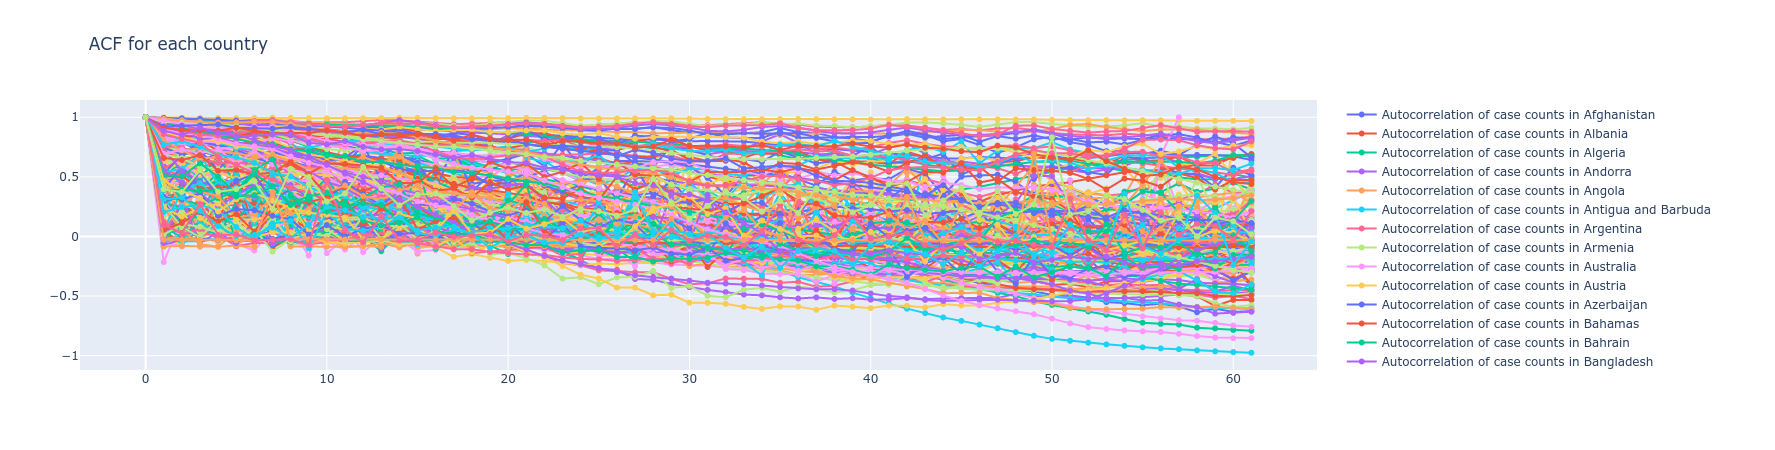

In [32]:
fig = go.Figure(data = [go.Scatter(y=autocorr_df[col],
                                   mode='lines+markers',
                                   name='Autocorrelation of case counts in ' + col
                                  ) for col in autocorr_df.columns]
               ).update_layout(title='ACF for each country',
                               showlegend=True
                              )
fig.show()

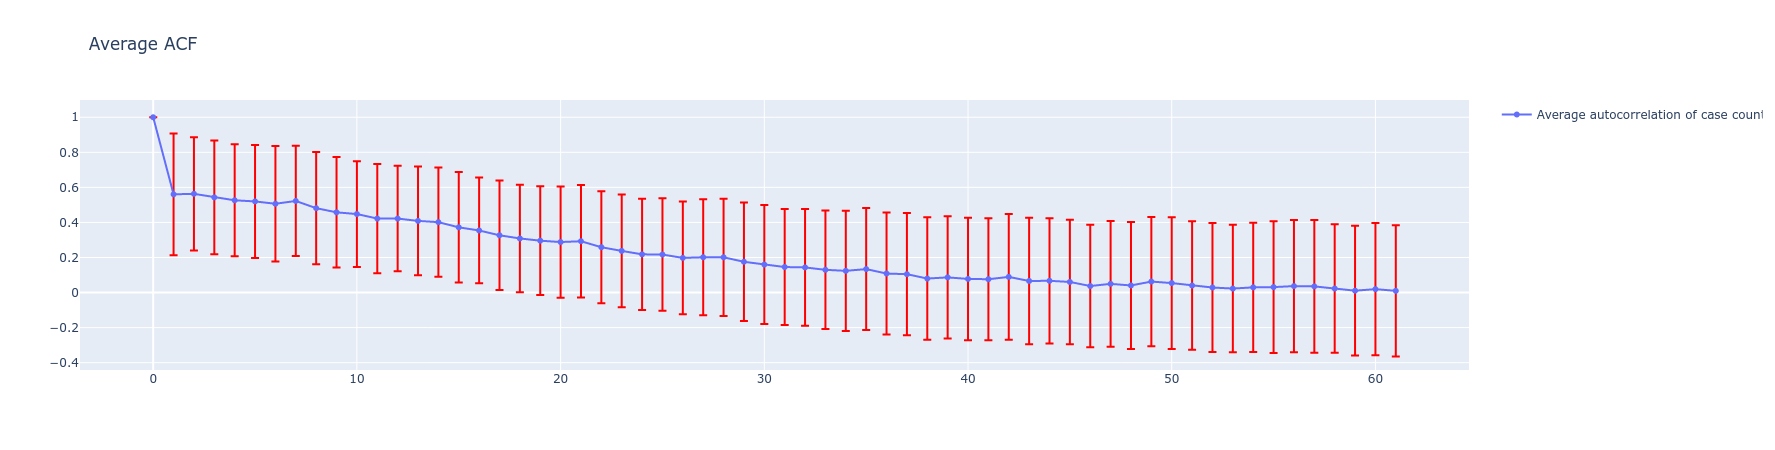

In [33]:
fig = go.Figure(data = go.Scatter(y=autocorr_df.mean(axis=1),
                                  mode='lines+markers',
                                  name='Average autocorrelation of case counts',
                                  error_y=dict(
                                      type='data',
                                      array=autocorr_df.std(axis=1),
                                      color='red',
                                      visible=True
                                  )
                                 )
               ).update_layout(title='Average ACF',
                              showlegend=True
                             )
fig.show()

The autocorrelations seem to be quite widely spread, and an ARIMA model or similar may not be effective at predicting the case counts. This also emphasises how the case counts for each country differ, and not including the idosyncrasies may result in reduced model performance. Perhaps a transformation of the underlying data should be considered, especially one that can make the process stationary.

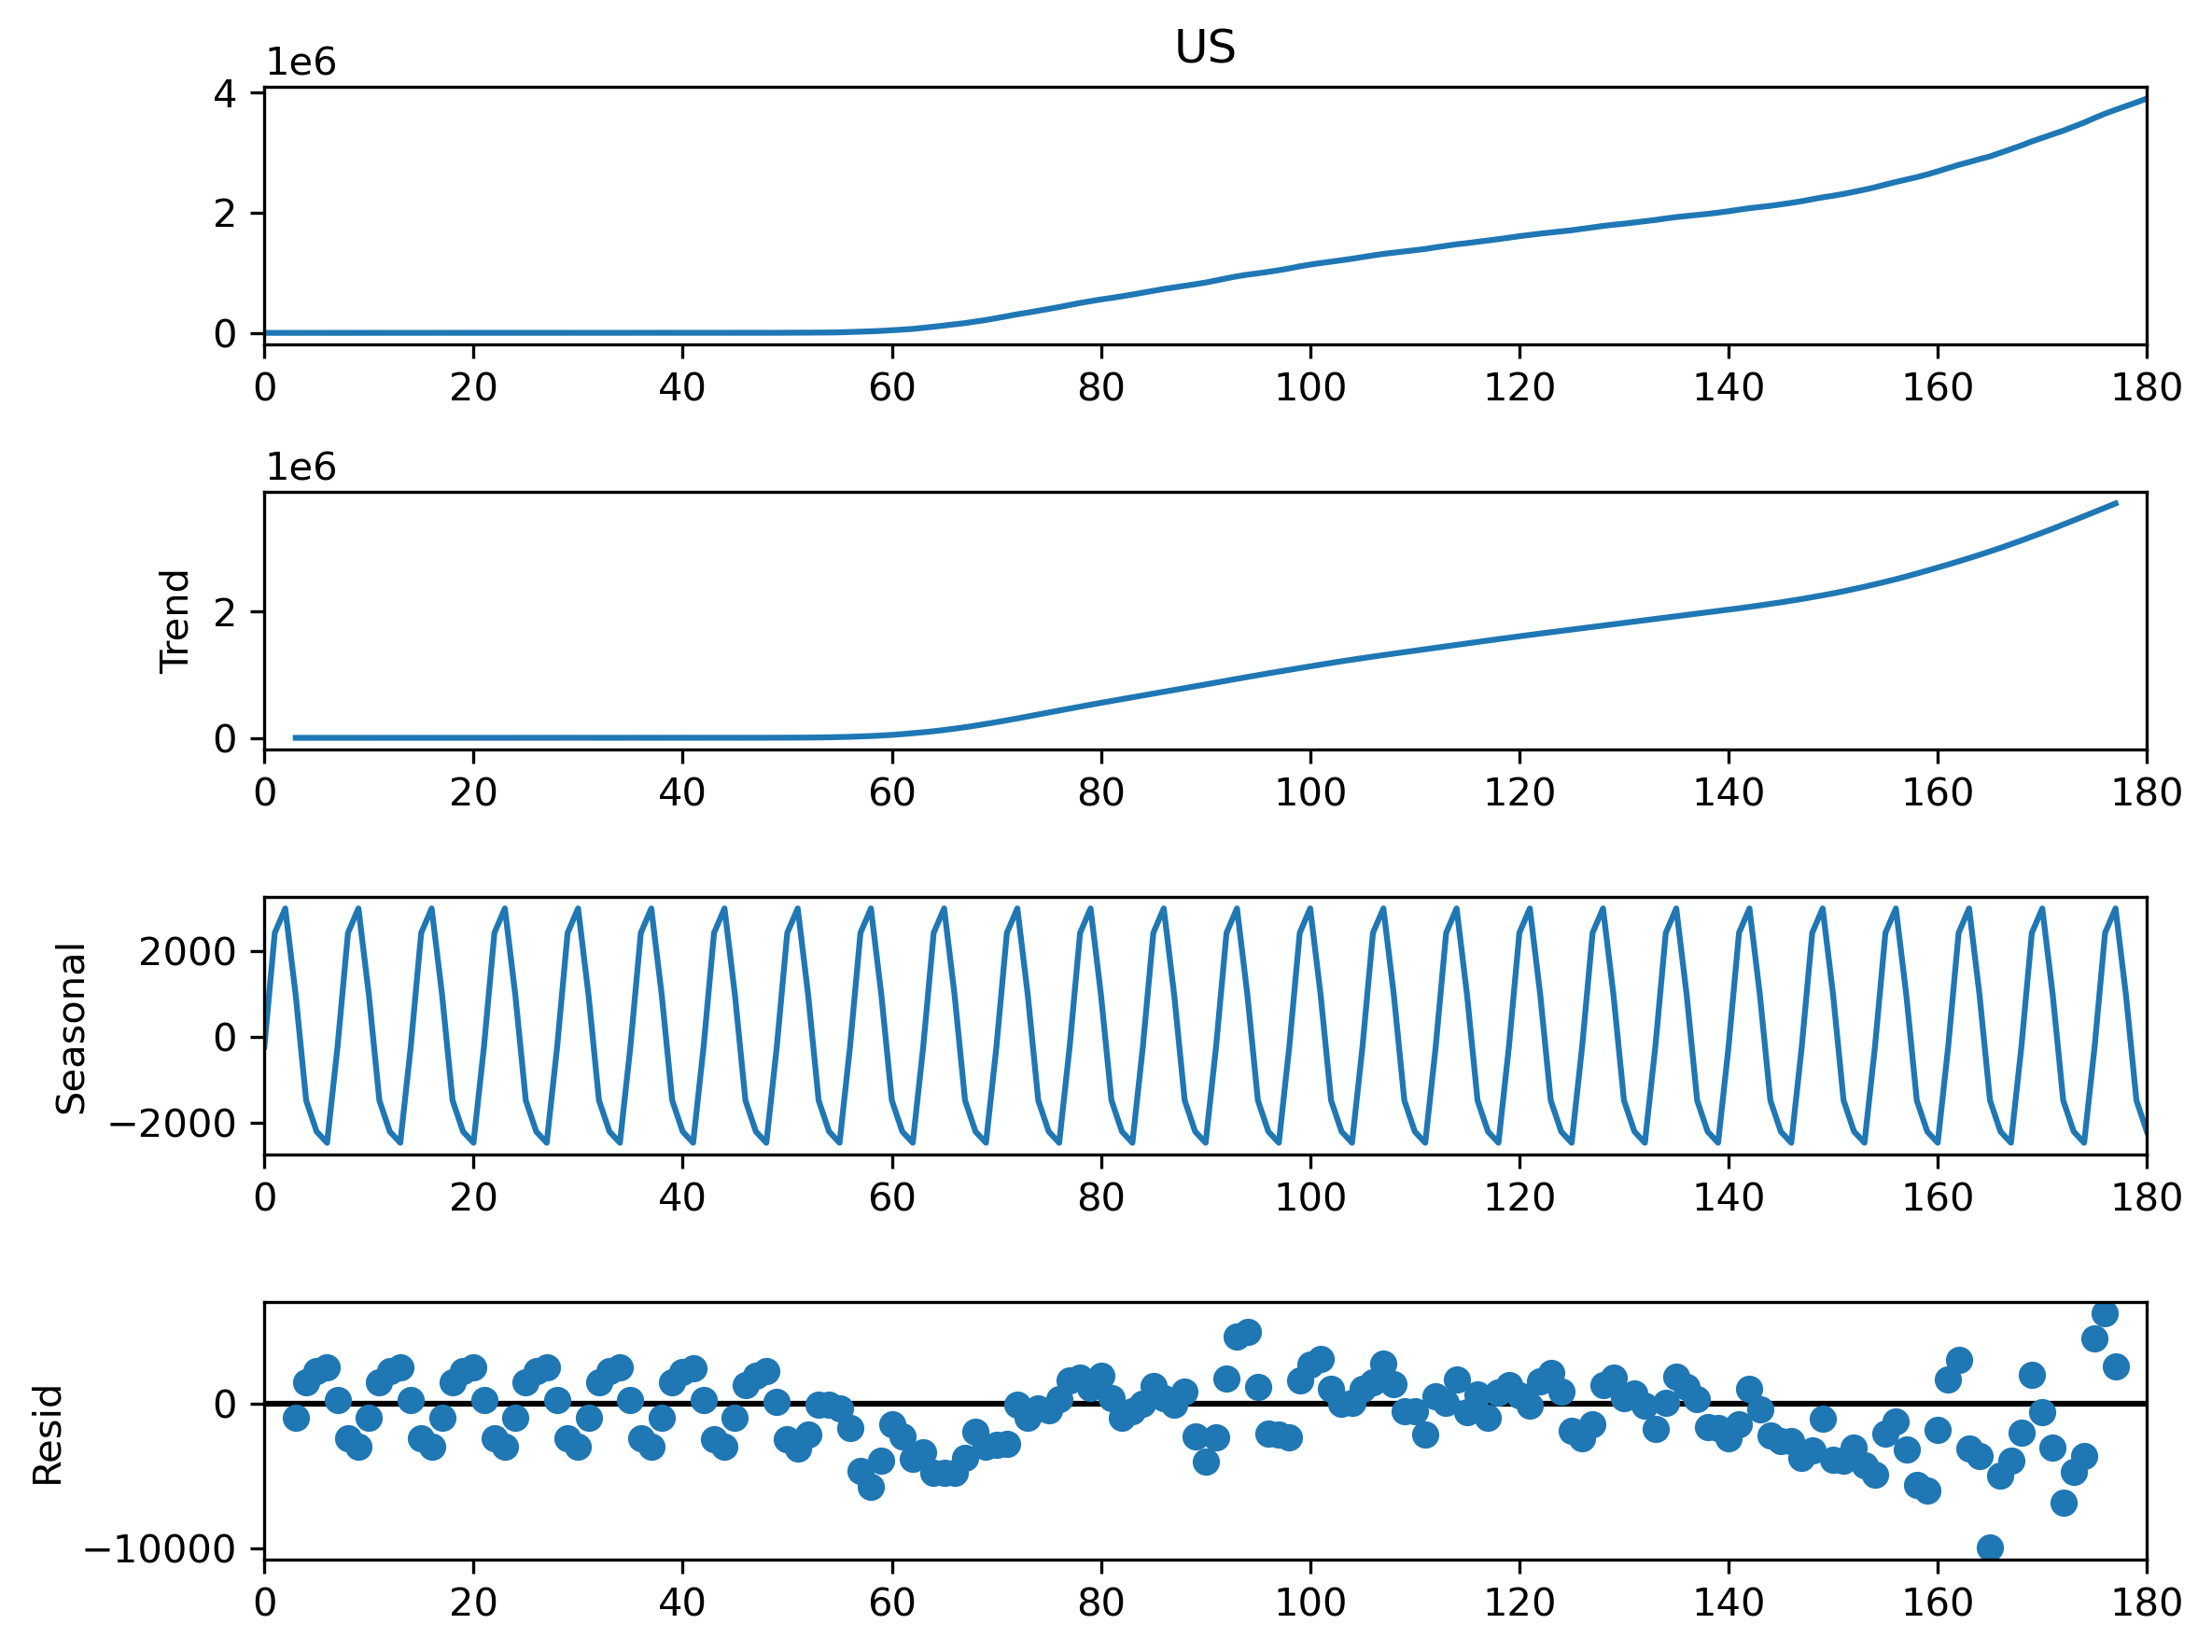

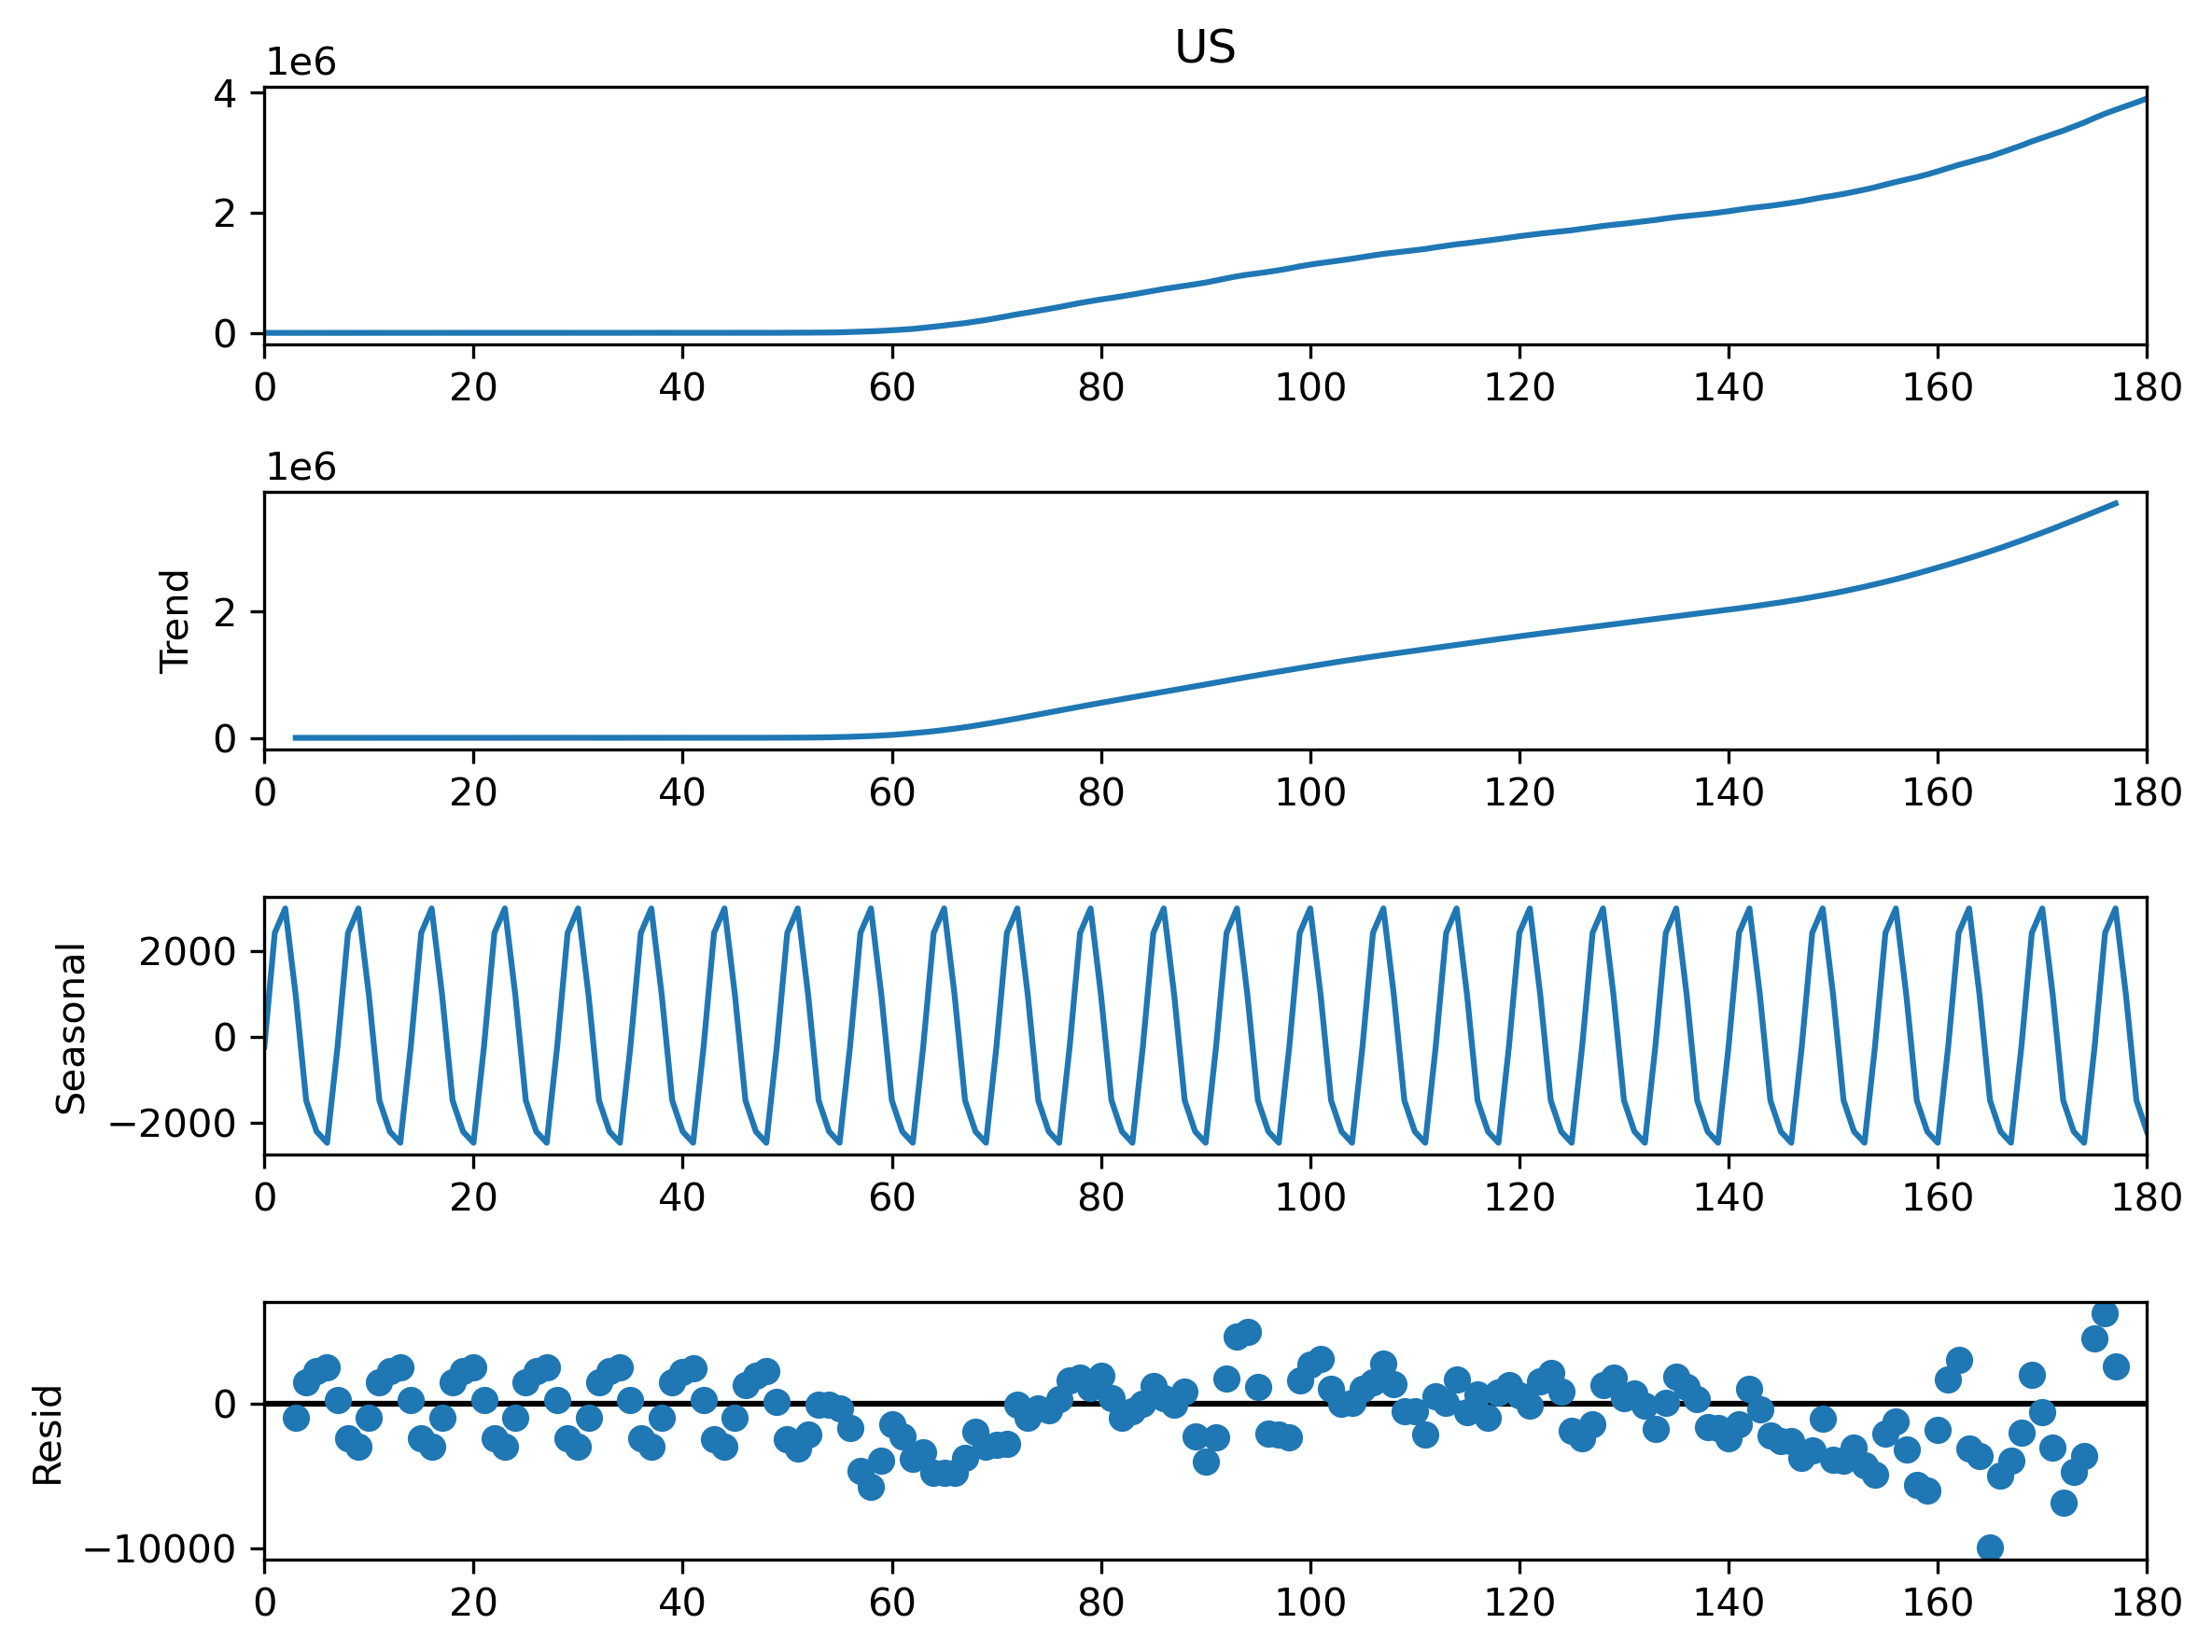

In [34]:
sm.tsa.seasonal_decompose(aligned_1['US'].dropna(), period=7).plot()

## Decision tree/Gradient Boosted Machine models


In [35]:
xg_train = xgb.DMatrix(data=train_val_df.iloc[:, :-1], label=train_val_df.iloc[:, -1])
xg_test = xgb.DMatrix(data=test_df.iloc[:, :-1], label=test_df.iloc[:, -1])

xg_params = {} # use default parameters for a basic model, see https://xgboost.readthedocs.io/en/latest/parameter.html

xgb_model = xgb.train(xg_params, xg_train)

Test set MSLE: 0.11925164356707474


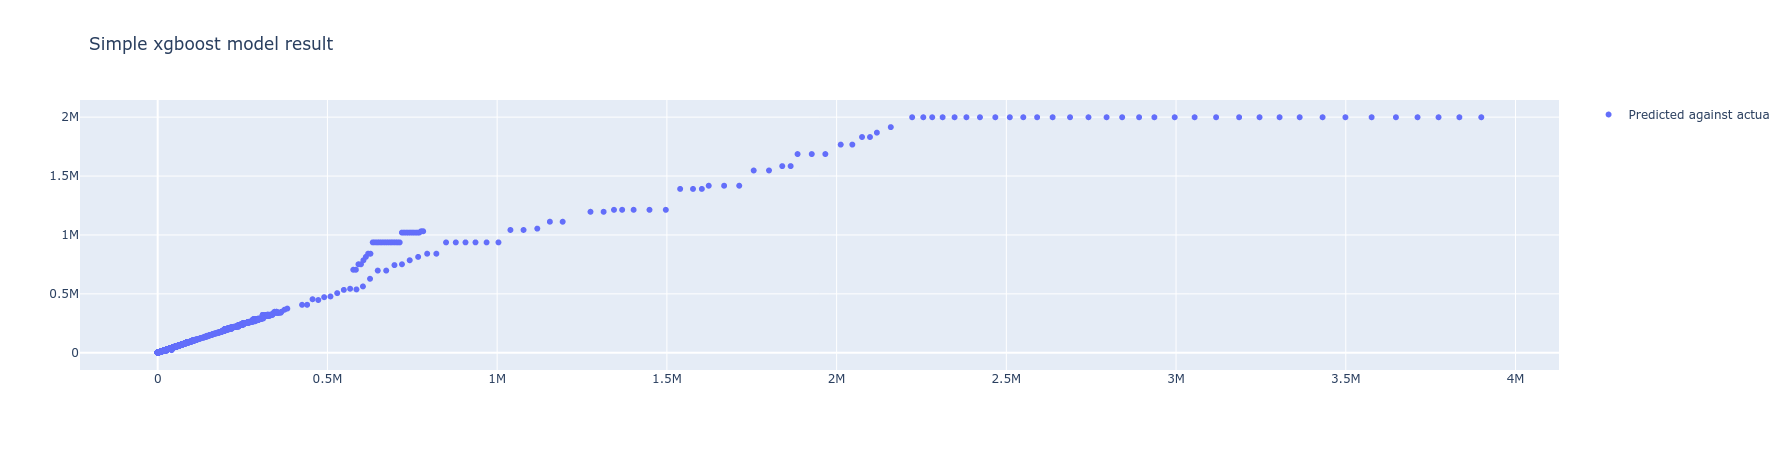

In [36]:
xg_test_pred = xgb_model.predict(xg_test)

print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], xg_test_pred)}")

fig = go.Figure(data = go.Scatter(x=test_df.iloc[:, -1],
                                  y=xg_test_pred,
                                  name='Predicted against actual',
                                  mode='markers'
                                 )
               ).update_layout(title='Simple xgboost model result',
                               showlegend=True
                              )
fig.show()

The MSLE from this simple model seems to be much higher than the linear regression model. However, this seems to be because of the outlier (countries) in USA and Brazil, which possess a disproportionately high case rate compared to other countries, resulting the focus of the leaves on lower values. This would present a problem with prediction moving forward, since the values increase with time, and also the case count in the USA is expected to increase even further.

As we are using the default parameters for simplicity, it is also a possibility that the selected parameters may not be a good fit for this model. Plotting the tree should give us a better idea of how it functions.

<AxesSubplot:>

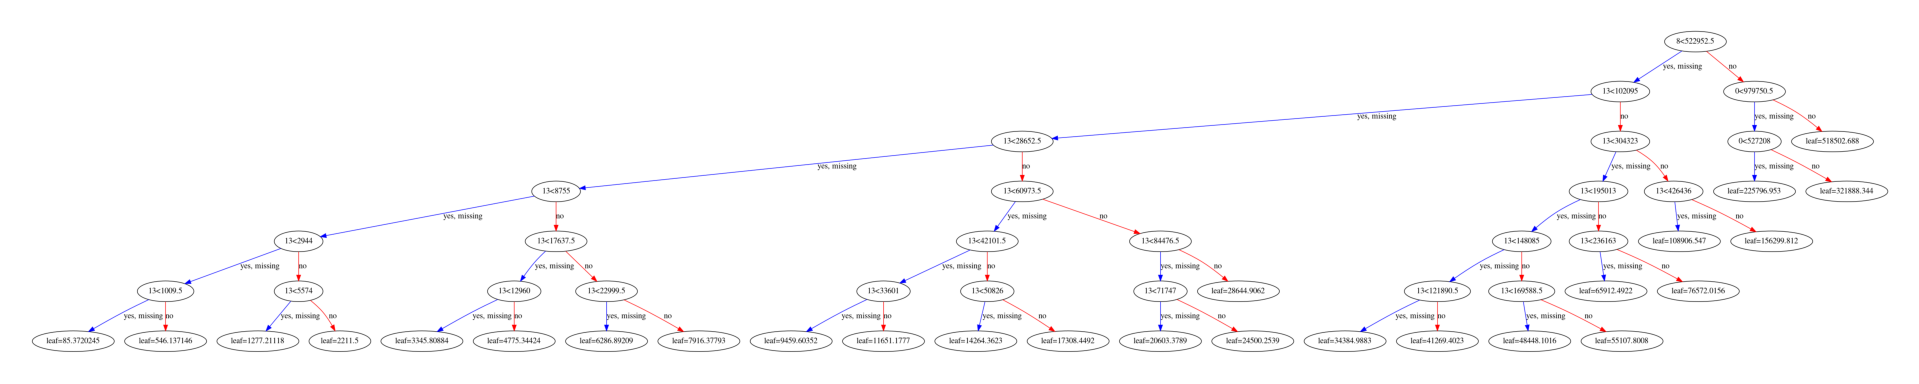

In [37]:
xgb.plot_tree(xgb_model)

According to this diagram, 13 is being used at all nodes but two, which use 0 and 9. 

In [38]:
xg_train.feature_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

## Neural network models
We next move on to neural network models. For the basic fully-connected neural network model, it is a simple, straightforward analogue of the linear regression done above. A few features (see the variables chosen for the linear regression) are used as inputs to the model. We will also look at models which accept sequences as inputs, which complicates matters. While it is perfectly fine to use the transformed dataset that we currently have, it also means that we may lose out on the benefits of the sequence models available to us, such as the ability to use the whole history of the data. It is also desirable for us to try to use the dynamics of the interaction between countries to predict the relationships between their case rates, something which cannot be done with the present dataset.

In [39]:
# Simple fully-connected 2 layer model

simple_fully_connected = tf.keras.models.Sequential([
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1)#, activation='relu')
])

simple_fully_connected.compile(optimizer='adam',
                               loss='msle',
                               metrics=['msle']
                              )

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

simple_fully_connected_history = simple_fully_connected.fit(x=train_df.iloc[:, :-1],
                                                            y=train_df.iloc[:, -1],
                                                            epochs=100,
                                                            callbacks=[lr_schedule],
                                                            verbose=1
                                                           )

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

435/435 [==============================] - 0s 918us/step - loss: 7.6245 - msle: 7.6245 - lr: 1.0000e-08
Epoch 2/100
435/435 [==============================] - 0s 688us/step - loss: 7.6243 - msle: 7.6243 - lr: 1.1220e-08
Epoch 3/100
435/435 [==============================] - 0s 692us/step - loss: 7.6240 - msle: 7.6240 - lr: 1.2589e-08
Epoch 4/100
435/435 [==============================] - 1s 1ms/step - loss: 7.6237 - msle: 7.6237 - lr: 1.4125e-08
Epoch 5/100
435/435 [=========================

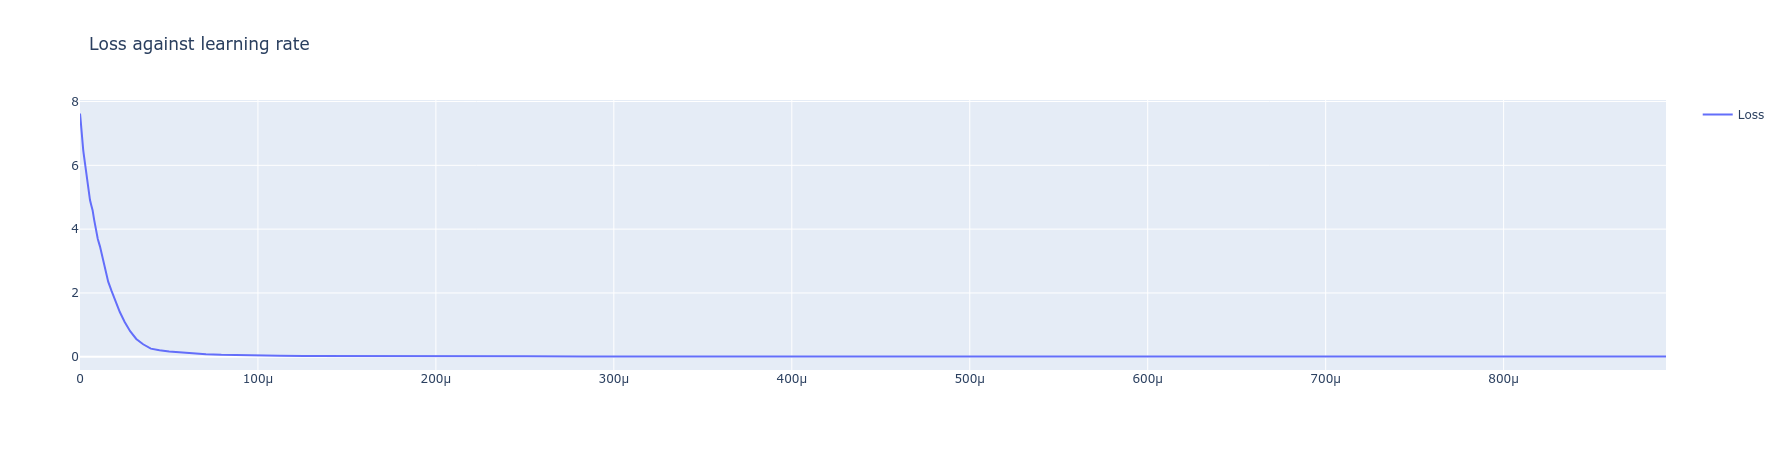

In [40]:
fig = go.Figure(data = go.Scatter(x=simple_fully_connected_history.history['lr'],
                                   y=simple_fully_connected_history.history['loss'],
                                   name='Loss'
                                  )
               ).update_layout(title='Loss against learning rate',
                               showlegend=True
                              )
fig.show()

In [41]:
val, idx = min((val, idx) for (idx, val) in enumerate(simple_fully_connected_history.history['loss']))
print(f"Minimum loss found at learning rate {simple_fully_connected_history.history['lr'][idx]} (epoch {idx}): {val}")

Minimum loss found at learning rate 0.0007943282253108919 (epoch 98): 0.007590114139020443


In [42]:
# Simple fully-connected 2 layer model with ReLU final layer activation

simple_fully_connected_relu = tf.keras.models.Sequential([
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

simple_fully_connected_relu.compile(optimizer='adam',
                                    loss='msle',
                                    metrics=['msle']
                                   )

simple_fully_connected_relu_history = simple_fully_connected_relu.fit(x=train_df.iloc[:, :-1],
                                                                      y=train_df.iloc[:, -1],
                                                                      epochs=100,
                                                                      callbacks=[lr_schedule],
                                                                      verbose=1
                                                                     )

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

435/435 [==============================] - 0s 739us/step - loss: 1.6264 - msle: 1.6264 - lr: 1.0000e-08
Epoch 2/100
435/435 [==============================] - 0s 714us/step - loss: 1.6255 - msle: 1.6255 - lr: 1.1220e-08
Epoch 3/100
435/435 [==============================] - 0s 778us/step - loss: 1.6244 - msle: 1.6244 - lr: 1.2589e-08
Epoch 4/100
435/435 [==============================] - 0s 692us/step - loss: 1.6232 - msle: 1.6232 - lr: 1.4125e-08
Epoch 5/100
435/435 [=======================

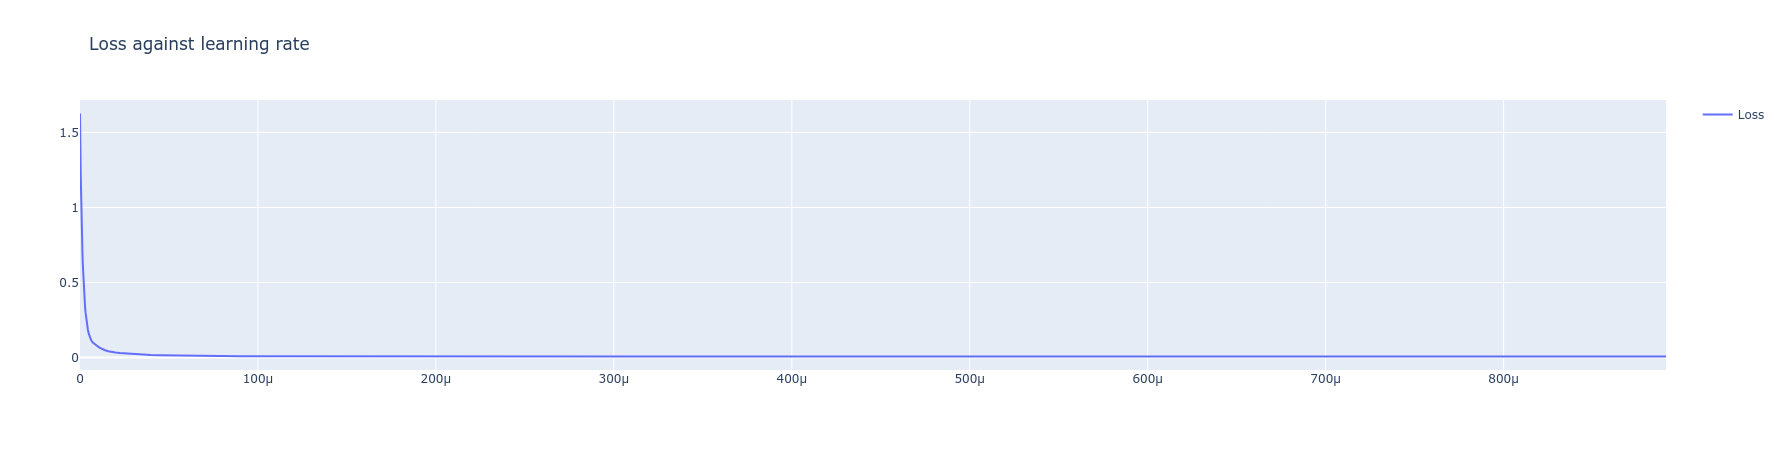

In [43]:
fig = go.Figure(data = go.Scatter(x=simple_fully_connected_relu_history.history['lr'],
                                   y=simple_fully_connected_relu_history.history['loss'],
                                   name='Loss'
                                  )
               ).update_layout(title='Loss against learning rate',
                               showlegend=True
                              )
fig.show()

In [44]:
val, idx = min((val, idx) for (idx, val) in enumerate(simple_fully_connected_relu_history.history['loss']))
print(f"Minimum loss found at learning rate {simple_fully_connected_relu_history.history['lr'][idx]} (epoch {idx}): {val}")

Minimum loss found at learning rate 0.0008912509656511247 (epoch 99): 0.007072280161082745


## Rearranging the split

In [45]:
train_df, val_df, test_df = datahandler.JHU.train_val_test_split(country_level_data)

In [46]:
train_df

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22                0        0        0        0       0   
2020-01-23                0        0        0        0       0   
2020-01-24                0        0        0        0       0   
2020-01-25                0        0        0        0       0   
2020-01-26                0        0        0        0       0   
...                     ...      ...      ...      ...     ...   
2020-06-23            29481     2047    12076      855     189   
2020-06-24            29640     2114    12248      855     197   
2020-06-25            30175     2192    12445      855     212   
2020-06-26            30451     2269    12685      855     212   
2020-06-27            30616     2330    12968      855     259   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                        0          0        0          0        0   
2020-01-23                        0          0        0          0        0   
2020-01-24                        0          0        0          0        0   
2020-01-25                        0          0        0          0        0   
2020-01-26                        0          0        0          4        0   
...                             ...        ...      ...        ...      ...   
2020-06-23                       26      47203    21006       7521    17408   
2020-06-24                       26      49851    21717       7558    17449   
2020-06-25                       65      52457    22488       7595    17477   
2020-06-26                       65      55343    23247       7601    17522   
2020-06-27                       65      57744    23909       7686    17580   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...               0        0           0          0        0   
2020-01-23      ...               0        0           0          0        2   
2020-01-24      ...               0        0           0          0        2   
2020-01-25      ...               0        0           0          0        2   
2020-01-26      ...               0        0           0          0        2   
...             ...             ...      ...         ...        ...      ...   
2020-06-23      ...          281038      885        6662       4187      349   
2020-06-24      ...          281815      902        6990       4366      352   
2020-06-25      ...          282512      907        7177       4563      352   
2020-06-26      ...          283151      919        7427       4779      353   
2020-06-27      ...          283785      924        7682       5130      355   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                       0               0      0       0         0  
2020-01-23                       0               0      0       0         0  
2020-01-24                       0               0      0       0         0  
2020-01-25                       0               0      0       0         0  
2020-01-26                       0               0      0       0         0  
...                            ...             ...    ...     ...       ...  
2020-06-23                    1169              10    992    1477       525  
2020-06-24                    1328              10   1015    1489       530  
2020-06-25                    1382              10   1076    1497       551  
2020-06-26                    1557              10   1089    1531       561  
2020-06-27                    1815              10   1103    1531       567  

[158 rows x 188 columns]

In [47]:
val_df

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-06-28            30967     2402    13273      855     267   
2020-06-29            31238     2466    13571      855     276   
2020-06-30            31517     2535    13907      855     284   
2020-07-01            31836     2580    14272      855     291   
2020-07-02            32022     2662    14657      855     315   
2020-07-03            32324     2752    15070      855     328   
2020-07-04            32672     2819    15500      855     346   
2020-07-05            32951     2893    15941      855     346   
2020-07-06            33190     2964    16404      855     346   
2020-07-07            33384     3038    16879      855     386   
2020-07-08            33594     3106    17348      855     386   
2020-07-09            33908     3188    17808      855     396   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-06-28                       69      59933    24645       7764    17654   
2020-06-29                       69      62268    25127       7834    17723   
2020-06-30                       69      64530    25542       7920    17766   
2020-07-01                       69      67197    26065       8001    17873   
2020-07-02                       69      69941    26658       8066    17941   
2020-07-03                       68      72786    27320       8260    18050   
2020-07-04                       68      75376    27900       8443    18165   
2020-07-05                       68      77815    28606       8583    18280   
2020-07-06                       70      80447    28936       8755    18365   
2020-07-07                       70      83426    29285       8886    18421   
2020-07-08                       70      87030    29820       9056    18513   
2020-07-09                       73      90693    30346       9374    18615   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-06-28      ...          284192      929        7948       5297      355   
2020-06-29      ...          284812      932        8222       5530      355   
2020-06-30      ...          285216      936        8503       5832      355   
2020-07-01      ...          285279      943        8781       6062      355   
2020-07-02      ...          285285      947        9078       6273      355   
2020-07-03      ...          285787      952        9396       6537      355   
2020-07-04      ...          286412      955        9708       6750      355   
2020-07-05      ...          286931      956       10020       7169      355   
2020-07-06      ...          287290      960       10362       7411      369   
2020-07-07      ...          287874      965       10838       7693      369   
2020-07-08      ...          288511      974       11092       8008      369   
2020-07-09      ...          289154      977       11564       8372      369   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-06-28                    1990              10   1118    1557       567  
2020-06-29                    2185              10   1128    1568       574  
2020-06-30                    2428              10   1158    1594       591  
2020-07-01                    2758              10   1190    1632       605  
2020-07-02                    3080              10   1221    1632       617  
2020-07-03                    3334              10   1240    1632       625  
2020-07-04                    3835              10   1248    1632       698  
2020-07-05                    4277              10   1265    1632       716  
2020-07-06                    4341              10   1284    1632       734  
2020-07-07                    4647              10   1297    1895       787  
2020-07-08                    5029              10   1318    1895       885  
2020-07-09                    5220              10   1356    1895       885  

[12 rows x 188 columns]

In [48]:
test_df

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-07-10            34194     3278    18242      855     458   
2020-07-11            34366     3371    18712      855     462   
2020-07-12            34451     3454    19195      855     506   
2020-07-13            34455     3571    19689      858     525   
2020-07-14            34740     3667    20216      861     541   
2020-07-15            34994     3752    20770      862     576   
2020-07-16            35070     3851    21355      877     607   
2020-07-17            35229     3906    21948      880     638   
2020-07-18            35301     4008    22549      880     687   
2020-07-19            35475     4090    23084      880     705   
2020-07-20            35526     4171    23691      884     749   
2020-07-21            35615     4290    24278      884     779   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-07-10                       74      94060    30903       9553    18709   
2020-07-11                       74      97509    31392       9797    18783   
2020-07-12                       74     100166    31969       9980    18897   
2020-07-13                       74     103265    32151      10251    18948   
2020-07-14                       74     106910    32490      10487    19021   
2020-07-15                       74     111146    33005      10810    19154   
2020-07-16                       74     114783    33559      11233    19270   
2020-07-17                       76     119301    34001      11441    19439   
2020-07-18                       76     122524    34462      11802    19573   
2020-07-19                       76     126755    34877      12069    19655   
2020-07-20                       76     130774    34981      12428    19743   
2020-07-21                       76     136118    35254      12894    19827   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-07-10      ...          289678      985       12027       8803      370   
2020-07-11      ...          290504      986       12513       9178      370   
2020-07-12      ...          291154      987       12997       9465      372   
2020-07-13      ...          291691      989       13591       9707      373   
2020-07-14      ...          292931      997       14085      10010      373   
2020-07-15      ...          293469     1009       14581      10428      381   
2020-07-16      ...          294116     1026       15066      10854      381   
2020-07-17      ...          294803     1037       15607      11191      382   
2020-07-18      ...          295632     1044       16186      11483      382   
2020-07-19      ...          296358     1054       16752      11891      383   
2020-07-20      ...          296944     1064       17149      12334      384   
2020-07-21      ...          297389     1096       17881      12774      401   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-07-10                    5551              10   1380    1895       942  
2020-07-11                    5931              10   1389    1895       982  
2020-07-12                    6230              10   1465    1895       985  
2020-07-13                    6566              10   1498    1895      1034  
2020-07-14                    6764              10   1516    1895      1064  
2020-07-15                    7064              10   1526    1895      1089  
2020-07-16                    7412              10   1552    1895      1362  
2020-07-17                    7764              10   1576    2810      1420  
2020-07-18                    8204              10   1581    2980      1478  
2020-07-19                    8549              10   1606    2980      1611  
2020-07-20                    8916              10   1619    3326      1713  
2020-07-21                    9228              10   1629    3386      1820  

[12 rows x 188 columns]

In [49]:
train_sequences, val_sequences, test_sequences = datahandler.JHU.train_val_test_split(country_level_data, 15)

In [50]:
train_sequences

0    1    2    3    4    5    6    7    8    9   10   11   12  \
Afghanistan    0    0    0    0    0    0    0    0    0    0    0    0    0   
Afghanistan    0    0    0    0    0    0    0    0    0    0    0    0    0   
Afghanistan    0    0    0    0    0    0    0    0    0    0    0    0    0   
Afghanistan    0    0    0    0    0    0    0    0    0    0    0    0    0   
Afghanistan    0    0    0    0    0    0    0    0    0    0    0    0    0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Zimbabwe     314  320  332  343  356  383  387  391  401  463  479  479  489   
Zimbabwe     320  332  343  356  383  387  391  401  463  479  479  489  512   
Zimbabwe     332  343  356  383  387  391  401  463  479  479  489  512  525   
Zimbabwe     343  356  383  387  391  401  463  479  479  489  512  525  530   
Zimbabwe     356  383  387  391  401  463  479  479  489  512  525  530  551   

              13   14  
Afghanistan    0    0  
Afghanistan    0    0  
Afghanistan    0    0  
Afghanistan    0    0  
Afghanistan    0    0  
...          ...  ...  
Zimbabwe     512  525  
Zimbabwe     525  530  
Zimbabwe     530  551  
Zimbabwe     551  561  
Zimbabwe     561  567  

[27072 rows x 15 columns]

In [51]:
test_sequences

0      1      2      3      4      5      6      7      8  \
Afghanistan  30451  30616  30967  31238  31517  31836  32022  32324  32672   
Afghanistan  30616  30967  31238  31517  31836  32022  32324  32672  32951   
Afghanistan  30967  31238  31517  31836  32022  32324  32672  32951  33190   
Afghanistan  31238  31517  31836  32022  32324  32672  32951  33190  33384   
Afghanistan  31517  31836  32022  32324  32672  32951  33190  33384  33594   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
Zimbabwe       625    698    716    734    787    885    885    942    982   
Zimbabwe       698    716    734    787    885    885    942    982    985   
Zimbabwe       716    734    787    885    885    942    982    985   1034   
Zimbabwe       734    787    885    885    942    982    985   1034   1064   
Zimbabwe       787    885    885    942    982    985   1034   1064   1089   

                 9     10     11     12     13     14  
Afghanistan  32951  33190  33384  33594  33908  34194  
Afghanistan  33190  33384  33594  33908  34194  34366  
Afghanistan  33384  33594  33908  34194  34366  34451  
Afghanistan  33594  33908  34194  34366  34451  34455  
Afghanistan  33908  34194  34366  34451  34455  34740  
...            ...    ...    ...    ...    ...    ...  
Zimbabwe       985   1034   1064   1089   1362   1420  
Zimbabwe      1034   1064   1089   1362   1420   1478  
Zimbabwe      1064   1089   1362   1420   1478   1611  
Zimbabwe      1089   1362   1420   1478   1611   1713  
Zimbabwe      1362   1420   1478   1611   1713   1820  

[2256 rows x 15 columns]

In [ ]:
# canonical import
country_level_data = datahandler.JHU.global_case_data()

train_df, val_df, test_df = datahandler.JHU.train_val_test_split(country_level_data)
train_sequences, val_sequences, test_sequences = datahandler.JHU.train_val_test_split(country_level_data, 15) # generates sequences of 14 days followed by 1-day prediction